UANL
Maestria en Ciencia de Datos 
Procesamiento y Clasificacion de Datos

Alder Lopez Cerda

El objetivo de este desarrollo es crear un algoritmo para comparar 2 coches y determinar el % de similitud, asi como determinar coches similares. 

Primero se realizara un analisis exploratorio de los datos para conocer lo que se tiene, y asi mismo por medio de procesamiento natural de lenguaje deteminar la similitud de palabras y asi realizar la comparacion.


In [221]:
#pip install --upgrade pip

In [222]:
#!pip install nltk
#!pip install gensim

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  
from time import time  
from collections import defaultdict  


In [2]:
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import spacy  # For preprocessing
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

Se cargara un conjunto de datos de automóviles incluye características como la marca, el modelo, el año, el motor y otras propiedades del automóvil. Usaremos estas funciones para generar incrustaciones de palabras para cada modelo de marca y luego compararemos las similitudes entre diferentes modelos de marca.

# Datos 

Kaggle Dataset( https://www.kaggle.com/CooperUnion/cardataset)

In [4]:
df = pd.read_csv('data.csv')
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [5]:
df.shape

(11914, 16)

In [6]:
df.describe()

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
count,11914.000000,11845.00000,11884.000000,11908.000000,11914.000000,11914.000000,11914.000000,1.191400e+04
mean,2010.384338,249.38607,5.628829,3.436093,26.637485,19.733255,1554.911197,4.059474e+04
std,7.579740,109.19187,1.780559,0.881315,8.863001,8.987798,1441.855347,6.010910e+04
min,1990.000000,55.00000,0.000000,2.000000,12.000000,7.000000,2.000000,2.000000e+03
25%,2007.000000,170.00000,4.000000,2.000000,22.000000,16.000000,549.000000,2.100000e+04
50%,2015.000000,227.00000,6.000000,4.000000,26.000000,18.000000,1385.000000,2.999500e+04
75%,2016.000000,300.00000,6.000000,4.000000,30.000000,22.000000,2009.000000,4.223125e+04
max,2017.000000,1001.00000,16.000000,4.000000,354.000000,137.000000,5657.000000,2.065902e+06


Resumen general de rows, columnas, datos nulos, duplicados.
Se hace una limpieza para reducir el sesgo de los resultados

In [38]:
def check_data(data):
    """a function to examine data for cleaning"""
    display(data.info())
    print(f'There are {data.shape} rows and column in the dataframe. \n')
    
    #    duplicate value   
    duplicate = data.duplicated().sum()
    if  duplicate == 0:
        print(f'There are {duplicate} duplicate rows in the dataframe')
    else:
        print(f'There are {duplicate} duplicate rows in the dataframe \n')
        
    #     missing value
    nan_data = pd.DataFrame(data.isna().sum().to_frame().reset_index().rename({'index': 'Variable', 
                                                                          0: 'Missing values'}, axis = 1))
    nan_df = nan_data[nan_data['Missing values'] >= 1]
    if nan_df['Missing values'].sum() >= 1:
        fig = px.bar(nan_df, 
                     x = 'Missing values', 
                     y = 'Variable',
                     title = 'Missing columns',
                     width = 600, 
                     height = 300, 
                     orientation = 'h', 
                     color_discrete_sequence  = ['darkgreen']) 
        fig.show()
    else:
        print('No missing value.')

    
check_data(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8084 entries, 0 to 11913
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               8084 non-null   object 
 1   Model              8084 non-null   object 
 2   Year               8084 non-null   int64  
 3   Engine Fuel Type   8084 non-null   object 
 4   Engine HP          8084 non-null   float64
 5   Engine Cylinders   8084 non-null   float64
 6   Transmission Type  8084 non-null   object 
 7   Driven_Wheels      8084 non-null   object 
 8   Number of Doors    8084 non-null   float64
 9   Market Category    8084 non-null   object 
 10  Vehicle Size       8084 non-null   object 
 11  Vehicle Style      8084 non-null   object 
 12  highway MPG        8084 non-null   int64  
 13  city mpg           8084 non-null   int64  
 14  Popularity         8084 non-null   int64  
 15  MSRP               8084 non-null   int64  
 16  Maker_Model        8084

None

There are (8084, 17) rows and column in the dataframe. 

There are 349 duplicate rows in the dataframe 

No missing value.


Se procede a eliminar duplicados

In [39]:
def remove_duplicate(data):
    print('\n Duplicate sample:\n')
    display(data[data.duplicated()][:3])
    
    # drop duplicate rows and keep first
    data = data.drop_duplicates(keep = 'first')
    print('\n Duplicate data have been removed from the dataset.')

remove_duplicate(df)


 Duplicate sample:



,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP,Maker_Model
14,BMW,1 Series,2013,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,19,3916,31500,BMW 1 Series
18,Audi,100,1992,regular unleaded,172.0,6.0,MANUAL,front wheel drive,4.0,Luxury,Midsize,Sedan,24,17,3105,2000,Audi 100
20,Audi,100,1992,regular unleaded,172.0,6.0,MANUAL,front wheel drive,4.0,Luxury,Midsize,Sedan,24,17,3105,2000,Audi 100



 Duplicate data have been removed from the dataset.


En el sig grafico pdoemos ver como se correlacionan las caracteristicas del dataset, ejemplo el MSRP (precio) esta muy relacionado al Enfine HP (Caballos de fuerza) asi como el numero de cilindros.

In [40]:

df.corr().style.background_gradient('copper_r')


,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
Year,1.000000,0.244256,-0.046552,0.182905,0.216441,0.180041,0.118304,0.133684
Engine HP,0.244256,1.000000,0.811390,-0.196042,-0.473019,-0.512779,0.038012,0.656662
Engine Cylinders,-0.046552,0.811390,1.000000,-0.178578,-0.603237,-0.615459,0.014825,0.589185
Number of Doors,0.182905,-0.196042,-0.178578,1.000000,0.103413,0.140205,-0.040450,-0.184699
highway MPG,0.216441,-0.473019,-0.603237,0.103413,1.000000,0.821349,0.032504,-0.257585
city mpg,0.180041,-0.512779,-0.615459,0.140205,0.821349,1.000000,0.037057,-0.268003
Popularity,0.118304,0.038012,0.014825,-0.040450,0.032504,0.037057,1.000000,-0.052477
MSRP,0.133684,0.656662,0.589185,-0.184699,-0.257585,-0.268003,-0.052477,1.000000


In [41]:
#sns.heatmap(df.corr(), cmap = 'copper_r', annot = True, lw = 0.1);

Podemos ver el total de Rows 

In [42]:
df.count()

Make                 8084
Model                8084
Year                 8084
Engine Fuel Type     8084
Engine HP            8084
Engine Cylinders     8084
Transmission Type    8084
Driven_Wheels        8084
Number of Doors      8084
Market Category      8084
Vehicle Size         8084
Vehicle Style        8084
highway MPG          8084
city mpg             8084
Popularity           8084
MSRP                 8084
Maker_Model          8084
dtype: int64

In [43]:
print(df.isnull().sum())

Make                 0
Model                0
Year                 0
Engine Fuel Type     0
Engine HP            0
Engine Cylinders     0
Transmission Type    0
Driven_Wheels        0
Number of Doors      0
Market Category      0
Vehicle Size         0
Vehicle Style        0
highway MPG          0
city mpg             0
Popularity           0
MSRP                 0
Maker_Model          0
dtype: int64


Se elimina los nulos con lo que el set de datos queda mas preparadado para evitar sesgos

In [44]:
df = df.dropna()
df.count()

Make                 8084
Model                8084
Year                 8084
Engine Fuel Type     8084
Engine HP            8084
Engine Cylinders     8084
Transmission Type    8084
Driven_Wheels        8084
Number of Doors      8084
Market Category      8084
Vehicle Size         8084
Vehicle Style        8084
highway MPG          8084
city mpg             8084
Popularity           8084
MSRP                 8084
Maker_Model          8084
dtype: int64

a continuacion podemos ver como influye el precio en relacion a los caballos de fuerza

<IPython.core.display.Javascript object>


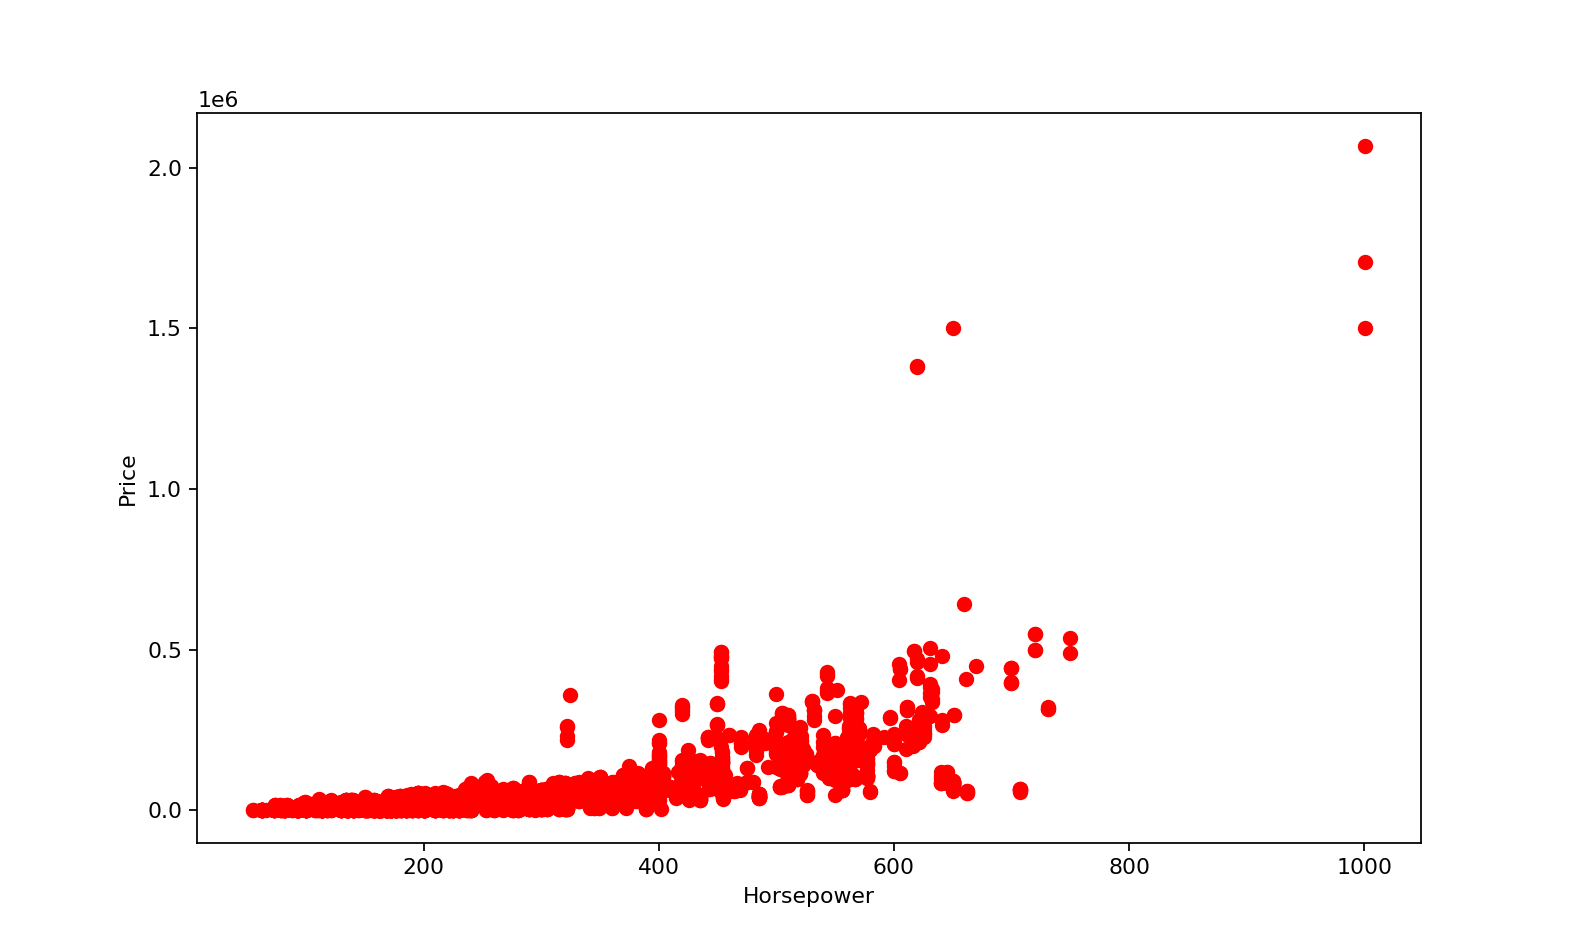

In [69]:
fig,ax = plt.subplots(figsize = (10,6))
ax.scatter(df['Engine HP'], df['MSRP'], c = 'Red')
ax.set_xlabel('Horsepower')
ax.set_ylabel('Price')
plt.show()

funcion para graficado de datos de columnas 

In [46]:


def value_count(data, category_col):
    """function to print number of unique values in category column and visualise the top 5 count"""
    if data[category_col].dtype == 'object':
        number_of_makers = data[category_col].nunique()
        print(f'Number of unique car {category_col} availabe in the dataset is: {number_of_makers}')
            
    framed_data = data[category_col].value_counts().to_frame().reset_index()[:5]
    fig = px.bar(framed_data, 
                 x = framed_data.iloc[:,0],
                 y = framed_data.iloc[:,1],
                 title = category_col,
                 height = 600,
                 width = 800,
                 color_discrete_sequence = ['darkgreen'], 
                 labels = {'x': category_col, 
                           'y': (f'count of {category_col}')}
                ) 
    fig.show()





Podemos ver que existen mas modelos de coches Chevrolet

In [47]:
value_count(df, 'Make')

Number of unique car Make availabe in the dataset is: 47


In [48]:
value_count(df, 'Model')

Number of unique car Model availabe in the dataset is: 713


Las marcas mas populares 

In [49]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x = df['Make'].unique(),
    y = df.groupby('Make').mean()['Popularity'].sort_values(ascending = False)[:10],
    marker_color = 'darkgreen'
))

fig.update_layout(title_text = 'Top 10 popular car brands',
                  xaxis_title = "car brand",
                  yaxis_title = "popularity")
fig.show()


podemos ver como los precios se dispararon apartir del 2000 y van fluctuando, esto tambien es importante a la hr de comprar un coche ya que al cliente le interesara que su coche no pierda mucho valor de re-venta 

In [50]:
mean_price_of_car_per_year = df.groupby('Year').mean()['MSRP']
count_of_cars_per_year = df.groupby('Year').count()['MSRP']

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x = mean_price_of_car_per_year.index,
        y = mean_price_of_car_per_year,
        name='mean of cars per year',
        marker_color = 'darkgreen'), 
    secondary_y=True,
)

fig.add_trace(go.Bar
              (x = count_of_cars_per_year.index,
               y = count_of_cars_per_year,
               name='count of cars per year',
               marker_color = 'darkgreen')
             )

# Set x-axis title
fig.update_xaxes(title_text = 'year')

# Set y-axes titles
fig.update_yaxes(title_text = "<b>Count</b> cars", secondary_y = False)
fig.update_yaxes(title_text = "<b>Mean MSRP</b> (in USD)", secondary_y = True)

# Here we modify the tickangle of the xaxis, resulting in rotated labels.
fig.update_layout(barmode = 'group', 
                  xaxis_tickangle = -45,
                  title_text = 'Yearly car count and mean price')

fig.show()

Podemos ver que el precio de los coches se concenran abajo del 0.5M 

In [51]:
def plot(data, value):
    """plot outliers in predicting class"""
    fig = px.box(data, y = value)
    fig.show()
    
plot(df, df['MSRP'])

# Preparar datos para el modelo de comparacion 

Para empezar para usar la libreria Genism word2Vec requerimos seleccionar las variables y en funcion de esto el formato para el entrenamiento donde cada documento está contenido en una lista y cada lista contiene una lista de tokens de ese documento. Primero, necesitamos generar  la lista de listas para entrenar la incrustación de palabras del modelo, dicho de otra forma,  cada modelo de marca está contenido en una lista y cada lista contiene una lista de características de ese modelo de marca. 
por lo que estaremos generando una mueva columna para el modelo, asi como generar el formato de listas para cada modelo usando: Engine Fuel Type, Transmission Type, Driven_Wheels, Market Category, Vehicle Size and Vehicle Style, MSRP/ tipo de combustible del motor, tipo de transmisión, ruedas motrices, categoría de mercado, tamaño del vehículo , estilo del vehículo y Precio.

Empezamos por agregar colunma Marca-Modelo para sirva de pivote en los datos


In [52]:
df['Maker_Model']= df['Make']+ " " + df['Model']

In [53]:
# Creamos el formato la lista de lista para cada marca modelo

df1 = df[['Engine Fuel Type',
          'Transmission Type',
          'Driven_Wheels',
          'Market Category',
          'Vehicle Size', 
          'Vehicle Style',
          'MSRP',
          'Maker_Model']]

# For each row, combine all the columns into one column
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1) 

# Store them in the pandas dataframe
df_clean = pd.DataFrame({'clean': df2}) 

# Crear lista de listas para modelo gensim  
sent = [row.split(',') for row in df_clean['clean']]

# muestra del formato para gensim modeling 
sent[:3] 

[['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Factory Tuner',
  'Luxury',
  'High-Performance',
  'Compact',
  'Coupe',
  '46135',
  'BMW 1 Series M'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'Performance',
  'Compact',
  'Convertible',
  '40650',
  'BMW 1 Series'],
 ['premium unleaded (required)',
  'MANUAL',
  'rear wheel drive',
  'Luxury',
  'High-Performance',
  'Compact',
  'Coupe',
  '36350',
  'BMW 1 Series']]

#  Word2vec Model  

Con Gensim para el procesamiento del lenguaje natural desarrollaremos la incrustación de palabras entrenando nuestros propios modelos word2vec en un corpus personalizado, ya sea con CBOW o con algoritmos salteados.

se va usar la funcion Word2Vec, la cual tiene estos parametros:

1. size: The number of dimensions of the embeddings and the default is 100.
2. window: The maximum distance between a target word and words around the target word. The default window is 5.
3. min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.
4. workers: The number of partitions during training and the default workers is 3. 
5. sg: The training algorithm, either CBOW(0) or skip gram (1). The default training alogrithm is CBOW.

In [54]:
## entrenamiento word2vec
model = Word2Vec(sent, min_count=1,workers=4, vector_size = 50, window =4, sg = 0)

    

INFO - 17:42:17: collecting all words and their counts
INFO - 17:42:17: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:42:17: collected 5412 word types from a corpus of 69369 raw words and 8084 sentences
INFO - 17:42:17: Creating a fresh vocabulary
INFO - 17:42:17: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 5412 unique words (100.00% of original 5412, drops 0)', 'datetime': '2022-07-24T17:42:17.406896', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 17:42:17: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 69369 word corpus (100.00% of original 69369, drops 0)', 'datetime': '2022-07-24T17:42:17.407578', 'gensim': '4.2.0', 'python': '3.8.8 (default, Apr 13 2021, 12:59:45) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'prepare_vocab'}
INFO - 17:42:17: deleting the raw counts dic

In [55]:
# incrustación  del modelo de entrenamiento
model.wv['Mazda 3'] 

array([ 0.08808793,  0.22619425,  0.07010157,  0.13084239,  0.1269947 ,
       -0.1350178 ,  0.10577126,  0.25443965, -0.12052597, -0.13624242,
        0.02292586, -0.17004362,  0.02780453, -0.05630066, -0.08271433,
        0.30583963,  0.27374637,  0.09003081, -0.25070956, -0.34850612,
        0.10425981,  0.16239065,  0.39096978, -0.13677876,  0.05482662,
        0.1061321 ,  0.03894066,  0.03452636, -0.05561889,  0.01676406,
        0.00573703, -0.096885  ,  0.06881423, -0.05923323, -0.11510002,
       -0.15591161,  0.19784717,  0.13098651, -0.02875319,  0.05793131,
        0.17525446, -0.03502084,  0.02892911,  0.10251105,  0.30526793,
        0.09967627, -0.00097551, -0.11128226,  0.33679545, -0.00315354],
      dtype=float32)

# Comparacion entre modelos 

Calculamos la similitud entre dos modelos de autos. El resultado de ese calculo ser la similitud euclidiana entre dos modelos.

In [56]:
model.wv.similarity('Chrysler 300','Mazda 3')

0.93172455

In [57]:
model.wv.similarity('Honda Civic','Mazda 3')

0.9825515

In [58]:
model.wv.similarity('Mazda CX-5', 'Hyundai Tucson')

0.98828286

# Obtener los mas similares a un determinado modelo

In [59]:
model.wv.most_similar('Mazda 3',topn=15)

[('Volkswagen Golf GTI', 0.9948391318321228),
 ('Nissan Juke', 0.9944387674331665),
 ('Volkswagen New Beetle', 0.9936171174049377),
 ('Subaru Impreza', 0.9935876727104187),
 ('Honda Crosstour', 0.9920660257339478),
 ('Honda Insight', 0.9916765689849854),
 ('Honda Fit', 0.9915714263916016),
 ('Volkswagen Golf', 0.9915392398834229),
 ('Toyota Yaris', 0.9906702041625977),
 ('Toyota Celica', 0.9906021356582642),
 ('Honda CR-Z', 0.9901686310768127),
 ('Toyota Prius', 0.9898527264595032),
 ('Acura Integra', 0.9891747236251831),
 ('Chevrolet Malibu Maxx', 0.9891102910041809),
 ('Chevrolet Spark', 0.988872766494751)]

In [60]:
model.wv.most_similar('Honda Civic')

[('DIRECT_DRIVE', 0.994495689868927),
 ('2dr SUV', 0.9936932325363159),
 ('Acura Integra', 0.993208110332489),
 ('electric', 0.9928044676780701),
 ('Volkswagen Beetle Convertible', 0.9922993779182434),
 ('Volkswagen Jetta GLI', 0.9917237162590027),
 ('Saab 9-3', 0.9913491606712341),
 ('Kia Forte', 0.9911722540855408),
 ('Volkswagen Golf', 0.9909101724624634),
 ('Ford Focus', 0.9906842708587646)]

In [61]:
model.wv.most_similar('Mazda CX-5',topn=15)

[('Honda Pilot', 0.995356559753418),
 ('Suzuki XL7', 0.9950904250144958),
 ('Buick Encore', 0.9950215220451355),
 ('Nissan Murano', 0.9935498833656311),
 ('Honda CR-V', 0.9934002161026001),
 ('Acura MDX', 0.9930644035339355),
 ('Wagon', 0.9927942752838135),
 ('Honda Element', 0.9927904605865479),
 ('Cadillac SRX', 0.9927482008934021),
 ('Mitsubishi Outlander', 0.992375373840332),
 ('Mazda Tribute', 0.9921900629997253),
 ('Chevrolet Equinox', 0.9920288920402527),
 ('Subaru Forester', 0.9919735193252563),
 ('Toyota RAV4', 0.9919065237045288),
 ('Dodge Journey', 0.991629421710968)]

In [62]:
model.wv.most_similar('Hyundai Tucson',topn=15)

[('Mazda Tribute', 0.9923228025436401),
 ('Wagon', 0.9921835064888),
 ('Honda Pilot', 0.9920149445533752),
 ('Volkswagen Tiguan', 0.9917832612991333),
 ('Land Rover Range Rover Evoque', 0.991435706615448),
 ('Honda Element', 0.9911062121391296),
 ('Honda CR-V', 0.9907884001731873),
 ('Saab 9-3', 0.990603506565094),
 ('Saab 9-3 Griffin', 0.990452766418457),
 ('Suzuki XL7', 0.9904230237007141),
 ('Volkswagen Jetta GLI', 0.9902441501617432),
 ('Nissan Murano', 0.9901913404464722),
 ('Nissan Rogue', 0.9897927045822144),
 ('Acura RDX', 0.989030659198761),
 ('Buick Encore', 0.9888485074043274)]

Como sabemos la distancia euclidiana pudiera no funcionar bien para los vectores de palabras de alta dimensión. Esto se debe a que la similitud euclidiana aumentará el número de dimensiones incluso si la palabra incrustación tiene diferentes significados. Por lo que aplicaremos la similitud del coseno para medir la similitud entre dos vectores.  Matemáticamente, es el coseno del ángulo entre dos vectores proyectados en un espacio multidimensional. Por lo tanto, la similitud del coseno es el ángulo de los vectores de palabras y no la magnitud. Bajo la similitud del coseno, ninguna similitud se expresa como un ángulo de 90 grados, mientras que la similitud total de 1 está en un ángulo de 0 grados. 

In [63]:
def cosine_distance (model, word,target_list , num) :
    
    cosine_dict ={}
    word_list = []
    a = model.wv[word] 
    
    for item in target_list :
        if item != word :
            b = model.wv [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) 
    
    for item in dist_sort:
        word_list.append((item[0], item[1]))
        
        
    return word_list[0:num]


In [64]:
Maker_Model = list(df.Maker_Model.unique()) ## se obtendra el unico de la relacion Maker_Model_Year

In [65]:
## mostrar los mas similares entre con el modelo en cuestion por similitud por coeseno
cosine_distance (model,'Mazda CX-5',Maker_Model,10) 

[('Honda Pilot', 0.99535644),
 ('Suzuki XL7', 0.9950904),
 ('Buick Encore', 0.9950215),
 ('Nissan Murano', 0.9935498),
 ('Honda CR-V', 0.9934002),
 ('Acura MDX', 0.99306434),
 ('Honda Element', 0.99279046),
 ('Cadillac SRX', 0.9927481),
 ('Mitsubishi Outlander', 0.9923754),
 ('Mazda Tribute', 0.99219006)]

In [66]:
## mostrar los mas similares entre con el modelo en cuestion 
cosine_distance (model,'Honda Civic',Maker_Model,10) 

[('Acura Integra', 0.99320817),
 ('Volkswagen Beetle Convertible', 0.9922994),
 ('Volkswagen Jetta GLI', 0.9917236),
 ('Saab 9-3', 0.9913492),
 ('Kia Forte', 0.9911721),
 ('Volkswagen Golf', 0.99091005),
 ('Ford Focus', 0.99068433),
 ('Toyota Matrix', 0.9906011),
 ('Volkswagen CC', 0.9904901),
 ('Pontiac Firebird', 0.9899348)]

Como vemos son muy similares en este caso los resultados de similitud por medio de distancia euclidiana y de coseno.

# T-SNE Plot

Usaremos T-SNE (t-distributed Stochastic Neighbor Embedding ) para visualizar datos de alta dimensión al reducir el espacio dimensional mientras se mantiene la distancia relativa por pares entre los puntos. T-SNE representa los datos conservando las relaciones de vecindad. 

In [67]:

def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.wv.similar_by_word(word)

    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()


<IPython.core.display.Javascript object>


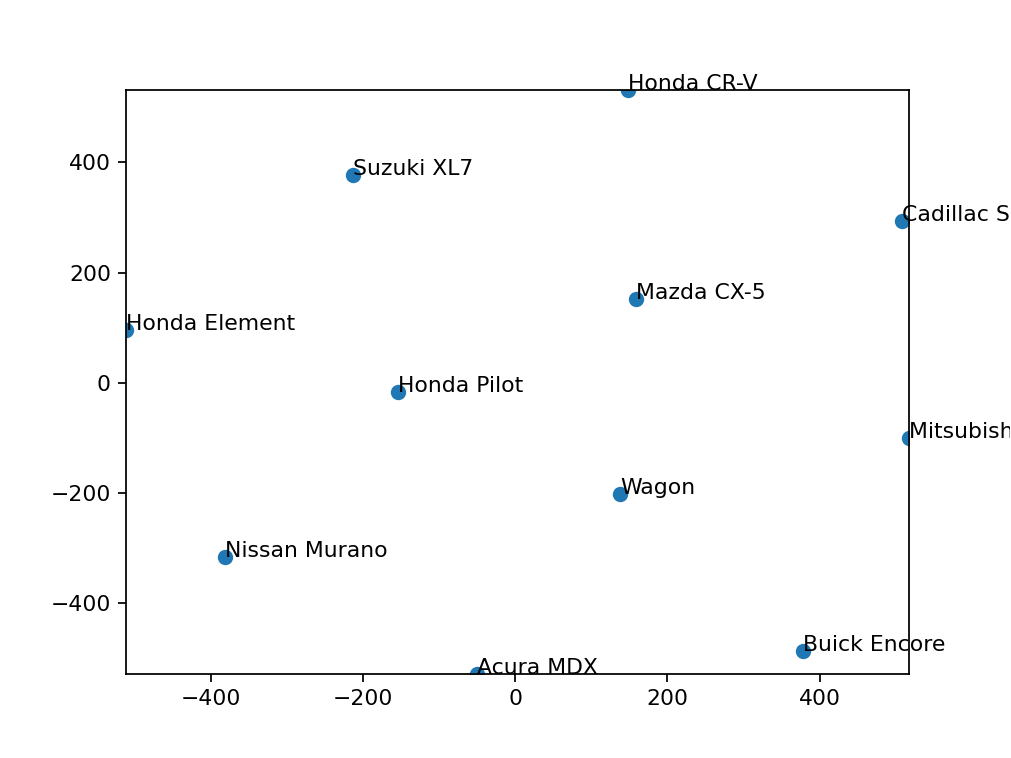

In [68]:
display_closestwords_tsnescatterplot(model, 'Mazda CX-5', 50)